In [1]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import pandas as pd
from astropy.constants import G, c, M_sun , hbar
import astropy.units as u
from scipy.optimize import fsolve

plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


# Dark matter

Adimensional 

$$

p' = \frac{p}{m_f^4} \qquad \epsilon' = \frac{\epsilon}{m_f^4}  \qquad  M' =  \frac{M}{a} \qquad R' =  \frac{R}{b}, \qquad a =  \frac{M_p^3}{m_f^2}, \qquad b = \frac{M_p}{m_f^2}
$$

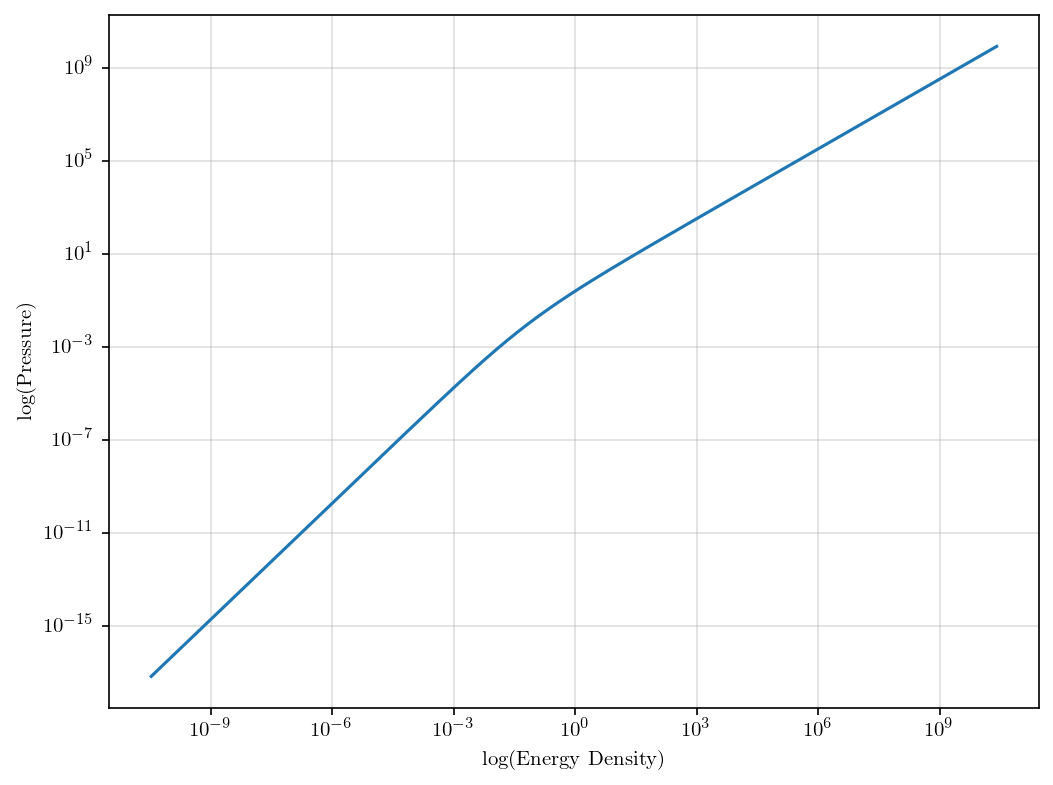

Maximum Pressure: 8443423526.851723
Maximum Energy Density: 25330321240.787254
Minimum Pressure: 6.752276061651133e-18
Minimum Energy Density: 3.37737380161332e-11


In [3]:
# The EoS is independent of the mass scale, so we can work in dimensionless units
def p(z):
    factor = 1 / (24 * np.pi**2)
    term1 = (2*z**3-3*z)
    term2 = (1+z**2)**0.5
    term3 = 3 * np.arcsinh(z)
    return factor * (term1*term2 + term3) # p'

def e(z):
    factor = 1 / (8 * np.pi**2)
    term1 = (2*z**3 + z)
    term2 = (1+z**2)**0.5
    term3 = np.arcsinh(z)
    return factor * (term1*term2 - term3) # e'

max_kf = 1e3
min_kf = 1e-3
number_points = int(1e6)

list_kf = np.linspace(min_kf, max_kf, number_points)

list_p_total = np.array(p(list_kf))
list_e_total = np.array(e(list_kf))

plt.figure(figsize=(8,6), dpi=150)
plt.plot(list_e_total, list_p_total)
plt.xlabel('log(Energy Density)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('log(Pressure)')
plt.grid()
plt.show()


plt.show()
#print maximums and minimums

max_pressure = np.max(list_p_total)
max_energy_density = np.max(list_e_total)
print(f'Maximum Pressure: {max_pressure}')
print(f'Maximum Energy Density: {max_energy_density}')
min_pressure = np.min(list_p_total)
min_energy_density = np.min(list_e_total)
print(f'Minimum Pressure: {min_pressure}')
print(f'Minimum Energy Density: {min_energy_density}')


# i want to cut list_e so it only has values between e_min and e_max

e_min = 1e-8
e_max = 10
mask = (list_e_total >= e_min) & (list_e_total <= e_max)
list_e = list_e_total[mask]
list_p = list_p_total[mask]

The range is adapted to recover minimum energy densiti 1e-8 and maximum 1e1

In [4]:
len(list_e), len(list_p)

(4398, 4398)

In [5]:

def solve_TOV(central_energy, x0):

    def ode_TOV(r, x):
        p, M = x

        e = np.interp(p, list_p, list_e)

        if r < 1e-8:
            dpdr = 0.0
            dMdr = 4*np.pi*r**2*e
            return [dpdr, dMdr]

        term1 = (e + p)
        term2 = (M + 4*np.pi*r**3*p)
        term3 = r * (r - 2*M)

        dpdr = - term1 * term2 / term3
        dMdr =  4*np.pi * r**2 * e

        return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 1e20),     # integrate up to r=1e5  corresponds to 
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]


    if P_surface > 1e-10 :
        print("Final pressure is far from 0:", P_surface * (m_f**4), 'MeV^4')
    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R = []
list_M = []




for i in range(0, len(list_e),5):
    e, p = list_e[i], list_p[i]
    r0 = 1e-6
    central_mass = (4/3) * np.pi * (r0**3) * e
    x0 = [p, central_mass]


    R_surface, M_surface = solve_TOV(e, x0)


    list_R.append(R_surface)
    list_M.append(M_surface)


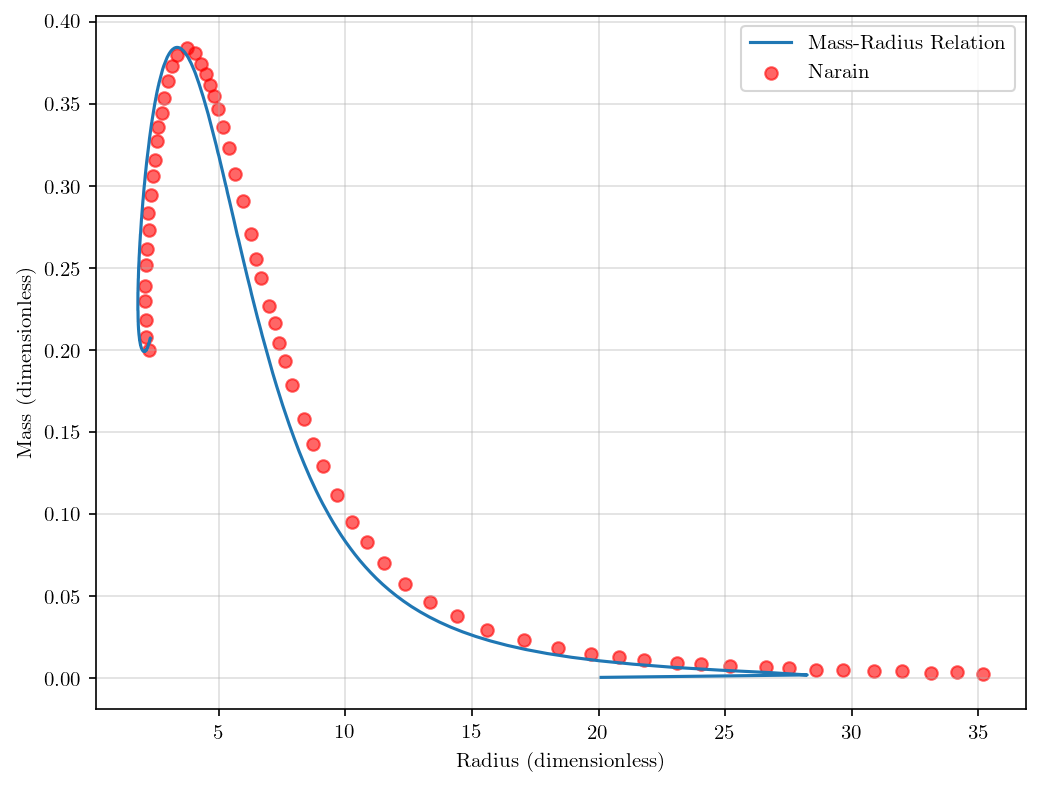

Maximum Mass: 0.38426354023420034 at Radius: 3.361459236211186


In [6]:
plt.figure(figsize=(8,6), dpi=150)

plt.plot(np.array(list_R), np.array(list_M), label='Mass-Radius Relation')


data = pd.read_csv('../Data/dimensionlessMR.csv')

plt.scatter(data['x'], data[' y'], color='red', label='Narain', alpha=0.6)

plt.xlabel('Radius (dimensionless)')
plt.ylabel('Mass (dimensionless)')
plt.grid()
plt.legend()
plt.show()
# maxum mass and radius
max_mass = np.max(list_M)
index_max_mass = np.argmax(list_M)
corresponding_radius = list_R[index_max_mass]
print(f'Maximum Mass: {max_mass} at Radius: {corresponding_radius}')


In [7]:
m_f = 100 * 1e3 # MeV = 100 GeV

m_planck = np.sqrt((hbar * c) / G) # kg

M_p = (m_planck * c**2).to(u.MeV).value  # MeV

a = M_p**3 / m_f**2
b = M_p / m_f**2

hc = 197.3269804 #MeV fm

Maximum Mass: 6.269342609831092e-05 M_sun
Radius at Maximum Mass: 0.8098244811647534 m


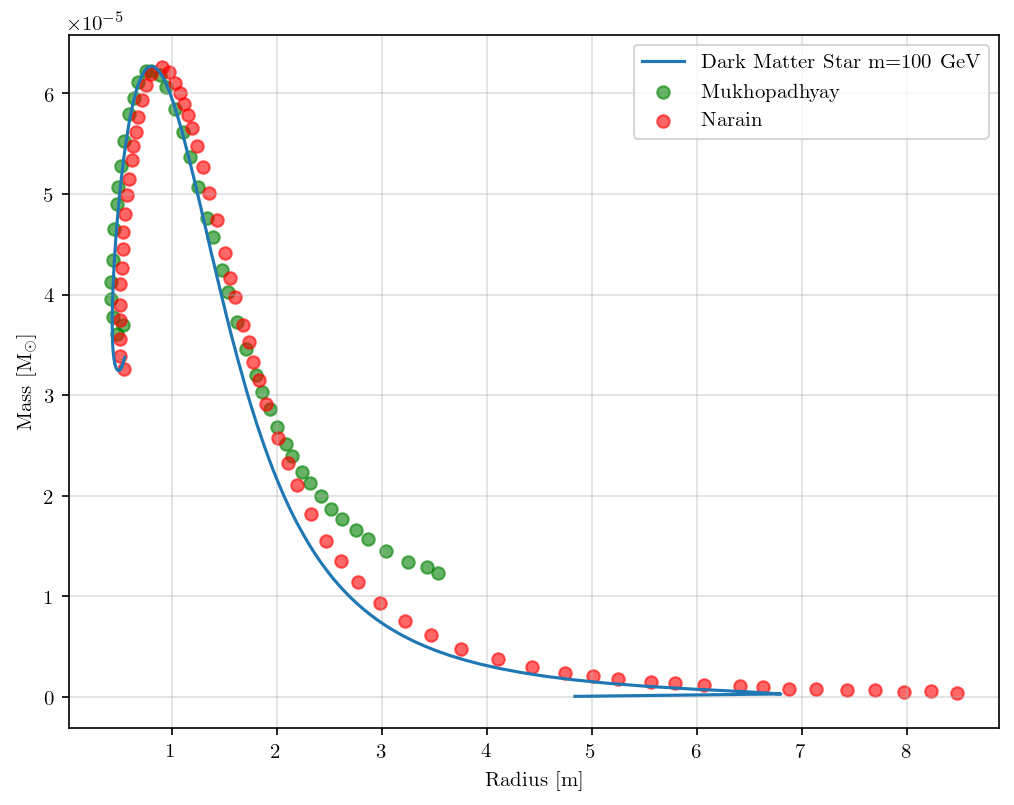

In [8]:
plt.figure(figsize=(8,6), dpi=150)
 
R_m = np.array(list_R) * b * 1e-15 * hc  # m

solar_mass_in_mev = M_sun.to(u.MeV / c**2).value
M_solar = np.array(list_M) * a / solar_mass_in_mev

plt.plot(R_m, M_solar, label=f'Dark Matter Star m={100} GeV')
plt.xlabel('Radius [m]')
plt.ylabel('Mass [M$_\odot$]')
plt.grid()



data_x = data['x'] * b * 1e-15 * hc  # m
solar_mass_in_mev = M_sun.to(u.MeV / c**2).value
data_y = data[' y'] * a / solar_mass_in_mev  # solar masses


#open external csv file 
data2 = pd.read_csv('../Data/mass_radius_dm.csv')

plt.scatter(data2['x']*1000, data2[' y'], color='green', label='Mukhopadhyay', alpha=0.6)
plt.scatter(data_x, data_y, color='red', label='Narain', alpha=0.6)

max_mass_index = np.nanargmax(list_M)
print("Maximum Mass:", M_solar[max_mass_index], "M_sun")
print("Radius at Maximum Mass:", R_m[max_mass_index], "m")


plt.legend()
plt.show()
